In [1]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")



In [3]:
query = """select *
        from eigensonne_dwh.public.lead_scoring_sample_1 """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()

,id,lead_source,lead_medium,lead_campaign,bundesland,closest_team,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Website,None,None,Schleswig-Holstein,hotel,35,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,Wattfox,affiliate,wattfox-standard,Bayern,echo,35,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,Wattfox,affiliate,wattfox-standard,Baden-Württemberg,india,35,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,Wattfox,affiliate,wattfox-standard,Bayern,echo,75,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,Wattfox,affiliate,wattfox-standard,Nordrhein-Westfalen,juliett,35,18,Regular,1,0,0,14,1


In [4]:
base.corr()

,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
distance,1.000000,-0.016429,-0.012081,-0.038599,0.019194,-0.037775
has_opened,-0.016429,1.000000,0.196205,0.157731,0.115755,0.198656
has_clicked_non_photo_url,-0.012081,0.196205,1.000000,0.137833,0.190204,0.221604
photo_upload,-0.038599,0.157731,0.137833,1.000000,-0.045678,0.374687
duration_photo_upload,0.019194,0.115755,0.190204,-0.045678,1.000000,0.275149
has_reached_wfp,-0.037775,0.198656,0.221604,0.374687,0.275149,1.000000


In [5]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

In [6]:
#taking into account that we always knows when leads come from affiliates, we will call the null values and 
#every lead comming from a source with a total of leads < 30 'Other'
data['lead_source'] = data['lead_source'].replace(np.nan, 'Others')
data['lead_source'] = data['lead_source'].replace(data.loc[data.groupby('lead_source').lead_source.transform('count').lt(30),
                               'lead_source'],'Others')

In [7]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a medium with a total of leads < 30 'Others'
data['lead_medium'] = data['lead_medium'].replace(np.nan, 'Others')
data['lead_medium'] = data['lead_medium'].replace(data.loc[data.groupby('lead_medium').lead_source.transform('count').lt(30),
                               'lead_medium'],'Others')

In [8]:
data = data.drop(['lead_campaign'],1)

In [9]:
dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
                        columns=['record_type_name_c','lead_source', 
                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

In [10]:
data = pd.concat([data, dummy1], axis=1)

In [11]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland', 'closest_team', 'radius_category',
                             'record_type_name_c'], axis = 1)

In [12]:
data.head(10)

,id,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Regular,record_type_name_c_Rent,lead_source_(direct),lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_(none),lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Baden-Württemberg,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,closest_team_alpha,closest_team_bravo,closest_team_delta,closest_team_echo,closest_team_foxtrot,closest_team_golf,closest_team_hotel,closest_team_india,closest_team_juliett,closest_team_kilo,closest_team_mike,radius_category_100,radius_category_150,radius_category_35,radius_category_75,radius_category_>150
0,00Q5J000002qx3WUAQ,24,1,0,0,14,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,00Q5J000002qx7dUAA,18,1,0,0,8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,00Q5J000002qx7jUAA,31,1,0,0,18,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,00Q5J000002qx7JUAQ,53,1,0,0,14,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,00Q5J000002qx7TUAQ,18,1,0,0,14,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,00Q5J000002qx7xUAA,14,0,0,0,40,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,00Q5J000002qx8bUAA,60,0,0,0,8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
7,00Q5J000002qx8lUAA,30,1,0,0,15,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,00Q5J000002qx9UUAQ,13,1,0,0,14,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
9,00Q5J000002qxaQUAQ,29,1,0,0,19,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [16]:
data.dtypes

id                                   object
distance                              int64
has_opened                            int64
has_clicked_non_photo_url             int64
photo_upload                          int64
duration_photo_upload                 int64
has_reached_wfp                       int64
record_type_name_c_Regular            uint8
record_type_name_c_Rent               uint8
lead_source_(direct)                  uint8
lead_source_Others                    uint8
lead_source_Wattfox                   uint8
lead_source_Wattfox-Premium           uint8
lead_source_Website                   uint8
lead_source_google                    uint8
lead_source_hausfrage                 uint8
lead_source_kp                        uint8
lead_source_outbrain                  uint8
lead_source_taboola                   uint8
lead_medium_(none)                    uint8
lead_medium_Others                    uint8
lead_medium_affiliate                 uint8
lead_medium_cpc                 

In [17]:
data_corr_1 = data[['distance','radius_category_100','radius_category_150','radius_category_35','radius_category_75','radius_category_>150']]
data_corr_1.corr()

,distance,radius_category_100,radius_category_150,radius_category_35,radius_category_75,radius_category_>150
distance,1.000000,0.288555,0.484037,-0.726044,0.329830,0.490266
radius_category_100,0.288555,1.000000,-0.039230,-0.204130,-0.183763,-0.023752
radius_category_150,0.484037,-0.039230,1.000000,-0.178670,-0.160843,-0.020790
radius_category_35,-0.726044,-0.204130,-0.178670,1.000000,-0.836939,-0.108178
radius_category_75,0.329830,-0.183763,-0.160843,-0.836939,1.000000,-0.097384
radius_category_>150,0.490266,-0.023752,-0.020790,-0.108178,-0.097384,1.000000


In [19]:
data_corr_1 = data[['has_opened','has_clicked_non_photo_url']]
data_corr_1.corr()

,has_opened,has_clicked_non_photo_url
has_opened,1.000000,0.196205
has_clicked_non_photo_url,0.196205,1.000000


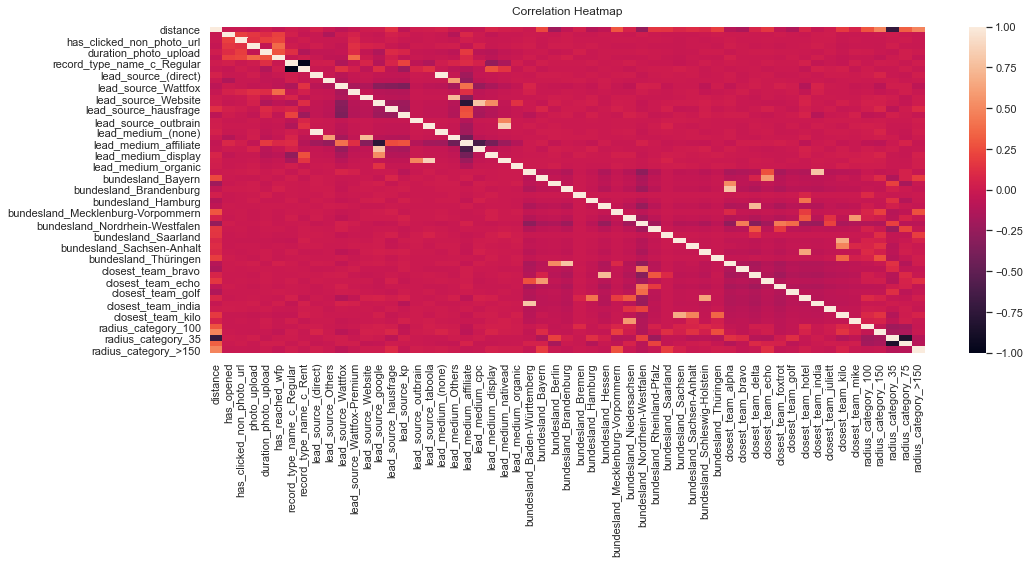

In [14]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);